In [7]:
import pandas as pd
import numpy as np

df_feature = pd.read_csv('../data_tran/extracted_feature.csv') #読み込み

In [8]:
df_feature.head(5)

,label,ax_A_mean,ax_A_std,ax_A_RMS,ax_A_energy,ax_A_entropy,ay_A_mean,ay_A_std,ay_A_RMS,ay_A_energy,...,ay_E_mean,ay_E_std,ay_E_RMS,ay_E_energy,ay_E_entropy,az_E_mean,az_E_std,az_E_RMS,az_E_energy,az_E_entropy
0,階段降り,-10095.115000,3193.308573,149738.816948,1.589442e+12,1.291517,2333.925000,2153.205443,44907.682160,1.143133e+11,...,1806.145000,1795.656586,36018.168568,1.110045e+11,3.056860,3081.645000,1990.262201,51880.014524,2.080846e+11,2.106770
1,階段降り,-10094.328125,3333.864469,170089.943336,2.651143e+12,1.374896,2014.660156,2457.361669,50842.456382,1.810564e+11,...,1706.808594,2366.021737,46678.486854,1.745063e+11,3.181850,3136.132812,2178.539603,61096.883210,3.458789e+11,2.148186
2,階段降り,-9774.820000,3475.480257,146714.736172,1.608769e+12,1.477448,1566.395000,2285.059553,39179.306923,1.376261e+11,...,1706.790000,2538.833273,43263.856717,1.574565e+11,3.429951,3067.520000,2349.352196,54642.720814,2.184749e+11,2.321673
3,階段降り,-9947.925781,4048.729614,171844.349174,2.704598e+12,1.440465,2117.660156,2588.711144,53512.549379,2.898369e+11,...,1509.148438,2764.306774,50390.909517,2.745205e+11,3.636137,3219.917969,2560.565715,65822.779773,3.814031e+11,2.482349
4,階段降り,-9877.695000,4102.551451,151261.222344,1.672245e+12,1.481259,2008.595000,2648.684368,47010.600411,2.397319e+11,...,1464.050000,2965.510483,46771.133897,1.341559e+11,3.441022,3302.915000,2665.429948,60022.936124,2.246754e+11,2.352513


In [68]:
print(df_feature["label"].value_counts())

歩いている    210
立っている    205
走っている    200
階段降り     199
階段上り     199
座っている    196
Name: label, dtype: int64


In [37]:
label_list = list(df_feature["label"].value_counts().keys())
print(label_list)
eng_label_dict = dict(zip(
    ['歩いている', '立っている', '走っている', '階段降り', '階段上り', '座っている'],
    ['Walking', 'Standing', 'Jogging', 'DownStair', 'Upstair', 'Sit']
))

eng_label_list = [eng_label_dict[i] for i in label_list]
print(eng_label_list)

['歩いている', '立っている', '走っている', '階段降り', '階段上り', '座っている']
['Walking', 'Standing', 'Jogging', 'DownStair', 'Upstair', 'Sit']


In [70]:
#ラベル名ごとにカウント
data_all = []
for activity_label in label_list:
    
    one_activity_data = df_feature[df_feature['label'] == activity_label]
    data_all.append(one_activity_data)
    

label_all = [activity_data.pop("label") for activity_data in data_all]

In [64]:
from sklearn.model_selection import KFold


def k_fold_eval(model):
    n_split = 10

    #KFoldの設定(5個に分割)
    kf = KFold(n_splits = n_split, shuffle = True, random_state = 42)

    k_index_list = []

    for activity_data in data_all:
        k_index_list.append(list(kf.split(activity_data)))
        
    all_test = []
    all_pred = []

    for k in range(n_split):

        train_x, train_y, test_x, test_y = [[] for _ in range(4)]
        
        for i, activity_data in enumerate(data_all):

            activity_x_train, activity_x_test = activity_data.values[ k_index_list[i][k][0] ], activity_data.values[ k_index_list[i][k][1] ]
            activity_y_train, activity_y_test = label_all[i].values[ k_index_list[i][k][0] ], label_all[i].values[ k_index_list[i][k][1] ]

            train_x.append(activity_x_train)
            test_x.append(activity_x_test)

            train_y.append(activity_y_train)
            test_y.append(activity_y_test)

        train_x = np.concatenate(train_x, axis=0)
        train_y = np.concatenate(train_y, axis=0)
        
        test_x = np.concatenate(test_x, axis=0)
        test_y = np.concatenate(test_y, axis=0)
        
        model.fit(train_x, train_y)
        
        y_pred = model.predict(test_x)
        
        all_test.extend(test_y)
        all_pred.extend(y_pred)
        
    return all_test, all_pred

### test with DecisionTreeClassifier

<AxesSubplot:>

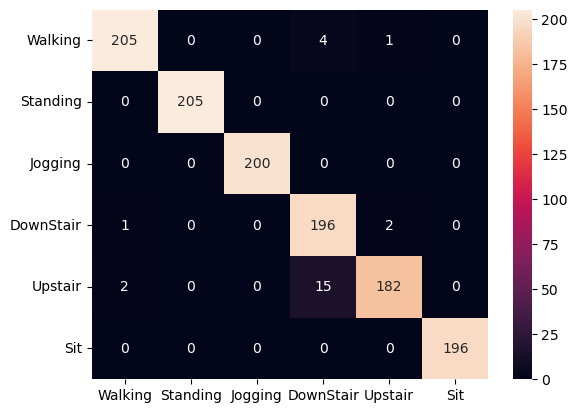

In [73]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
import seaborn as sns

Model = tree.DecisionTreeClassifier(criterion='gini', min_samples_leaf=1 , max_depth=6) # モデル構造の定義

all_test, all_pred = k_fold_eval(Model)
cf = confusion_matrix(all_test, all_pred, labels=label_list)
sns.heatmap(cf, annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')

In [66]:
from sklearn.metrics import precision_recall_fscore_support

print("precision_recall_fscore_support: ")
print()
print(*eng_label_list, sep=" "*4)
print(*precision_recall_fscore_support(all_test, all_pred, labels=label_list), sep="\n")

precision_recall_fscore_support: 

Walking    Standing    Jogging    DownStair    Upstair    Sit
[0.98557692 1.         1.         0.91162791 0.98387097 1.        ]
[0.97619048 1.         0.995      0.98492462 0.91959799 1.        ]
[0.98086124 1.         0.99749373 0.9468599  0.95064935 1.        ]
[210 205 200 199 199 196]


### test with SVM

<AxesSubplot:>

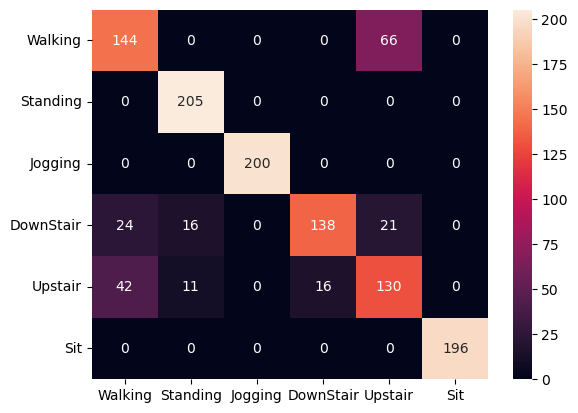

In [67]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
import seaborn as sns

Model = svm.SVC(kernel='rbf', degree=5) # モデル構造の定義

all_test, all_pred = k_fold_eval(Model)
cf = confusion_matrix(all_test, all_pred, labels=label_list)
sns.heatmap(cf, annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')

In [62]:
from sklearn.metrics import precision_recall_fscore_support

print("precision_recall_fscore_support: ")
print()
print(*eng_label_list, sep=" "*4)
print(*precision_recall_fscore_support(all_test, all_pred, labels=label_list), sep="\n")

precision_recall_fscore_support: 

Walking    Standing    Jogging    DownStair    Upstair    Sit
[0.68571429 0.88362069 1.         0.8961039  0.59907834 1.        ]
[0.68571429 1.         1.         0.69346734 0.65326633 1.        ]
[0.68571429 0.9382151  1.         0.78186969 0.625      1.        ]
[210 205 200 199 199 196]
